In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, METRIC_DIFF_MOD_AGNOSTIC_MOD_SPECIFIC, METRIC_CROSS_DECODING, RIDGE_DECODER_ATTN_MOD_OUT_DIR, ATTENTION_MOD_SUBJECTS
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS, TRAINING_MODES, CAPTION, IMAGE, TEST_SPLITS
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix, dist_mat_to_pairwise_acc
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, ACC_MEAN, ACC_CROSS_MEAN, PALETTE_BLACK_ONLY, METRICS_ERROR_ANALYSIS, get_data_default_feats, METRICS_BASE, calc_model_feat_order, FEATS_MULTIMODAL, DEFAULT_FEAT_OPTIONS

In [37]:
def load_results_data():
    data = []

    result_files = sorted(glob(f"{RIDGE_DECODER_ATTN_MOD_OUT_DIR}/*/*/*/results.csv"))
    for result_file_path in tqdm(result_files):
        results = pd.read_csv(result_file_path)
        data.append(results)

    data = pd.concat(data, ignore_index=True)
    data["mask"] = data["mask"].fillna("whole_brain")

    return data

data = load_results_data()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(data)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:01<00:00, 120.05it/s]


,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,mask,num_voxels,surface,resolution,training_splits
0,test_image,0.899379,False,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,/home/mitja/data/multimodal_decoding/searchlig...,39029,True,fsaverage7,NaN
1,test_image,0.912008,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,/home/mitja/data/multimodal_decoding/searchlig...,39029,True,fsaverage7,NaN
2,test_image,0.910187,False,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,/home/mitja/data/multimodal_decoding/searchlig...,39029,True,fsaverage7,NaN
3,test_image,0.914988,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,/home/mitja/data/multimodal_decoding/searchlig...,39029,True,fsaverage7,NaN
4,test_caption,0.793168,False,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,/home/mitja/data/multimodal_decoding/searchlig...,39029,True,fsaverage7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,test_caption_unattended,0.564389,True,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,whole_brain,296041,True,fsaverage7,NaN
7782,test_caption_unattended,0.521663,False,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,whole_brain,296041,True,fsaverage7,NaN
7783,test_caption_unattended,0.562763,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,whole_brain,296041,True,fsaverage7,NaN
7784,imagery,0.833333,all_imagery,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,whole_brain,296041,True,fsaverage7,NaN


In [38]:
print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.standardized_predictions == 'True')][['metric', 'value', 'latents']])

                      metric     value                    latents
477               test_image  0.910352  limited_candidate_latents
479               test_image  0.910304      all_candidate_latents
481             test_caption  0.826915  limited_candidate_latents
483             test_caption  0.827635      all_candidate_latents
485      test_image_attended  0.891097  limited_candidate_latents
487      test_image_attended  0.893560      all_candidate_latents
489    test_caption_attended  0.781573  limited_candidate_latents
491    test_caption_attended  0.784895      all_candidate_latents
493    test_image_unattended  0.891097  limited_candidate_latents
495    test_image_unattended  0.893208      all_candidate_latents
497  test_caption_unattended  0.678882  limited_candidate_latents
499  test_caption_unattended  0.678337      all_candidate_latents
501                  imagery  1.000000  limited_candidate_latents
503                  imagery  0.868852      all_candidate_latents
505       

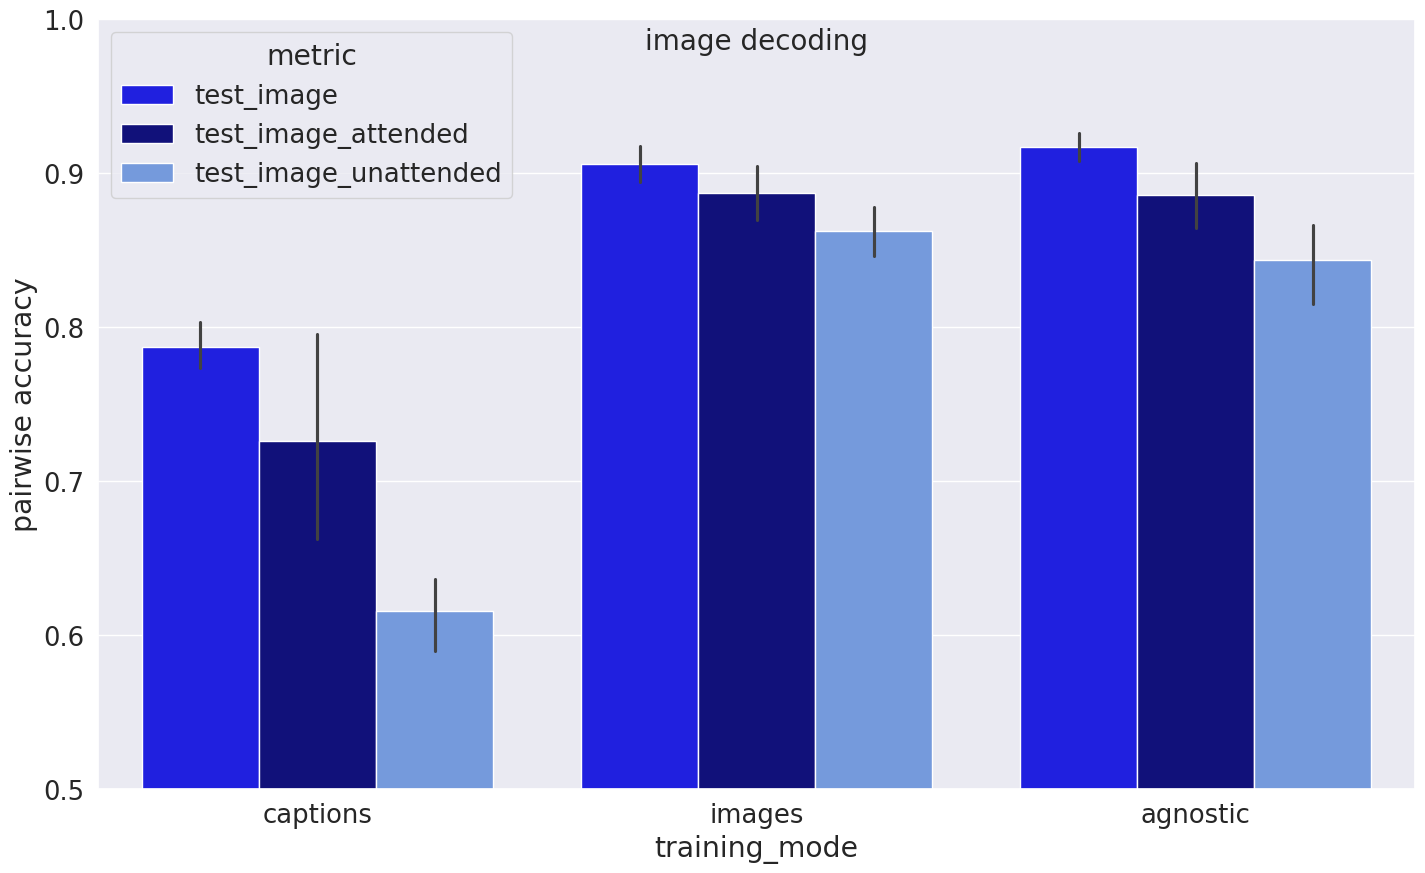

In [5]:
filtered = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'

filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered['mask'] == MASK]

# print(filtered.groupby(['metric', 'training_mode']).agg(num_subjects=('value', 'size')).reset_index())
assert len(filtered) == len(ATTENTION_MOD_SUBJECTS) * len(filtered.metric.unique()) * len(filtered.training_mode.unique())

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image', 'test_image_attended', 'test_image_unattended']#, 'imagery', 'imagery_weak']
PALETTE = ['blue', 'darkblue', 'cornflowerblue']
sns.set(font_scale=1.7)
plt.figure(figsize=(17, 10))
plt.title('image decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=filtered, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylim((0.5, 1))
plt.ylabel('pairwise accuracy')
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_images.png"), bbox_inches='tight', pad_inches=0, dpi=300)


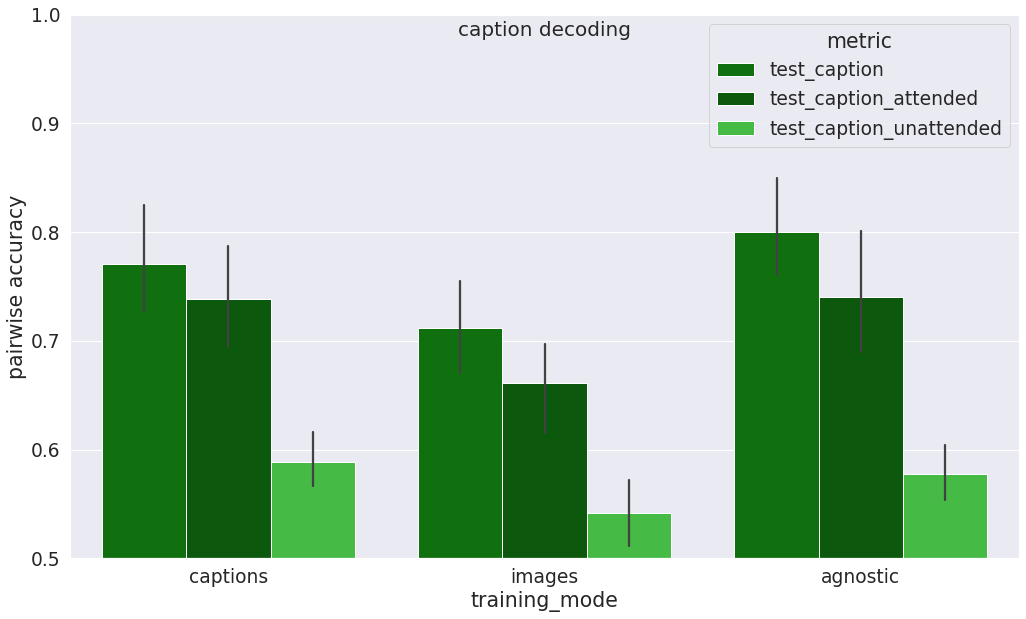

In [131]:
filtered = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'

filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered['mask'] == MASK]

# print(filtered.groupby(['metric', 'training_mode']).agg(num_subjects=('value', 'size')).reset_index())
assert len(filtered) == len(ATTENTION_MOD_SUBJECTS) * len(filtered.metric.unique()) * len(filtered.training_mode.unique())

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption', 'test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak']
PALETTE = ['green', 'darkgreen', 'limegreen']
sns.set(font_scale=1.7)
plt.figure(figsize=(17,10))
plt.title('caption decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=filtered, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_captions.png"), bbox_inches='tight', pad_inches=0, dpi=300)


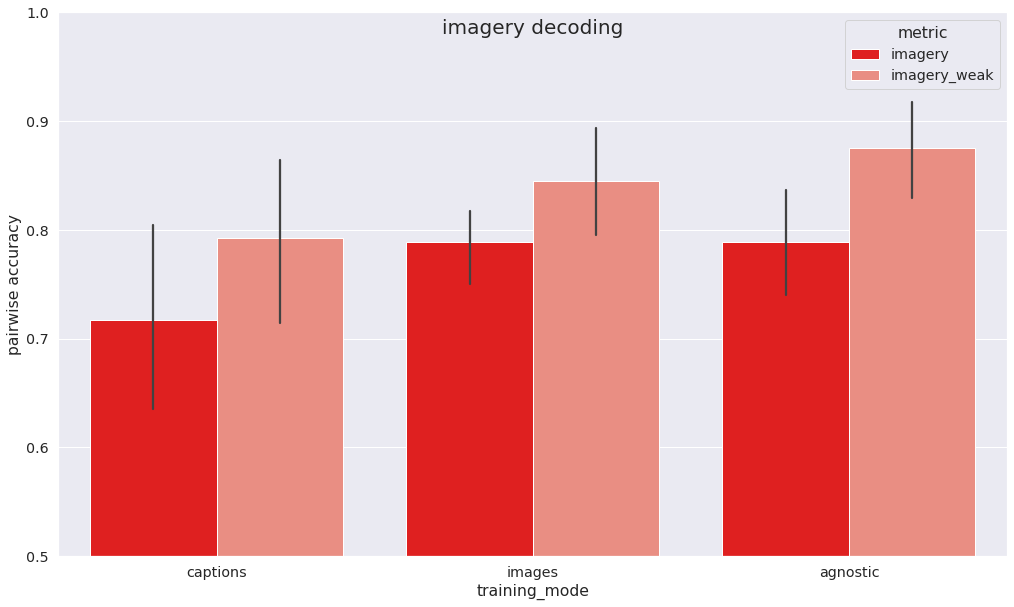

In [132]:
filtered = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'

filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered['mask'] == MASK]

# print(filtered.groupby(['metric', 'training_mode']).agg(num_subjects=('value', 'size')).reset_index())
assert len(filtered) == len(ATTENTION_MOD_SUBJECTS) * len(filtered.metric.unique()) * len(filtered.training_mode.unique())

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['imagery', 'imagery_weak']
PALETTE = ['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(17,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=filtered, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


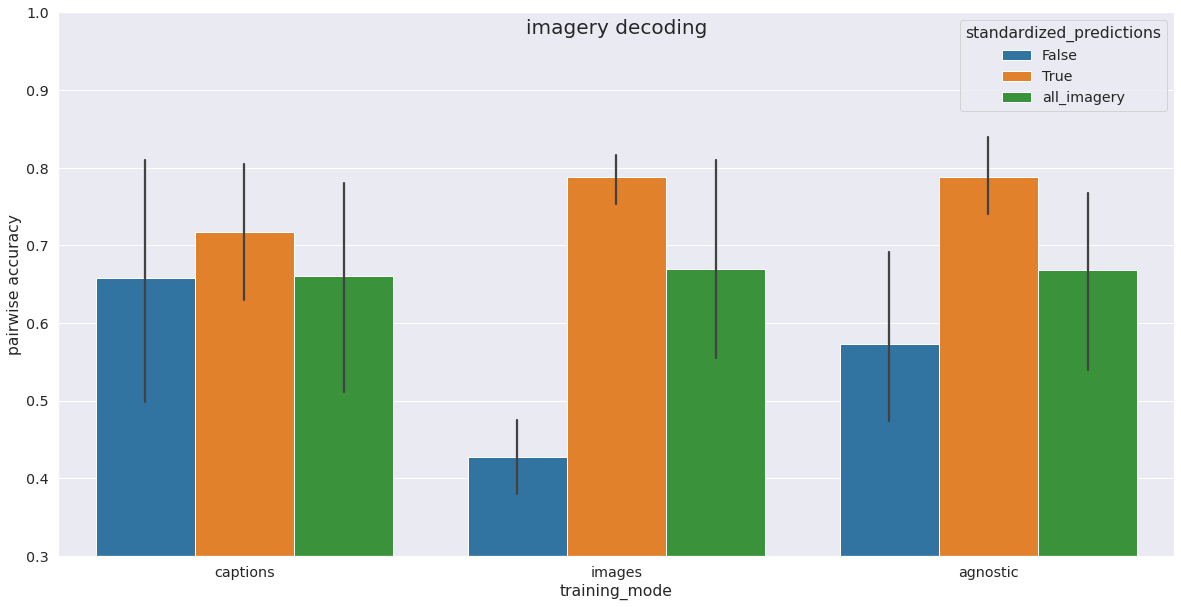

In [133]:
filtered = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'

# filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered.metric == 'imagery']

filtered = filtered[filtered['mask'] == MASK]

assert len(filtered) == len(ATTENTION_MOD_SUBJECTS) * len(filtered.standardized_predictions.unique()) * len(filtered.training_mode.unique())

ORDER = ['captions', 'images', 'agnostic']
# HUE_ORDER = ['imagery', 'imagery_weak']
HUE_ORDER = None

PALETTE = 'tab10'#['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=filtered, x="training_mode", y="value", hue="standardized_predictions", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


100%|██████████| 225/225 [00:00<00:00, 520.27it/s]
<ipython-input-152-837f21dba396>:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  ax = sns.barplot(data=filtered, x="mask", y="value", hue="metric", hue_order=HUE_ORDER, palette=PALETTE)


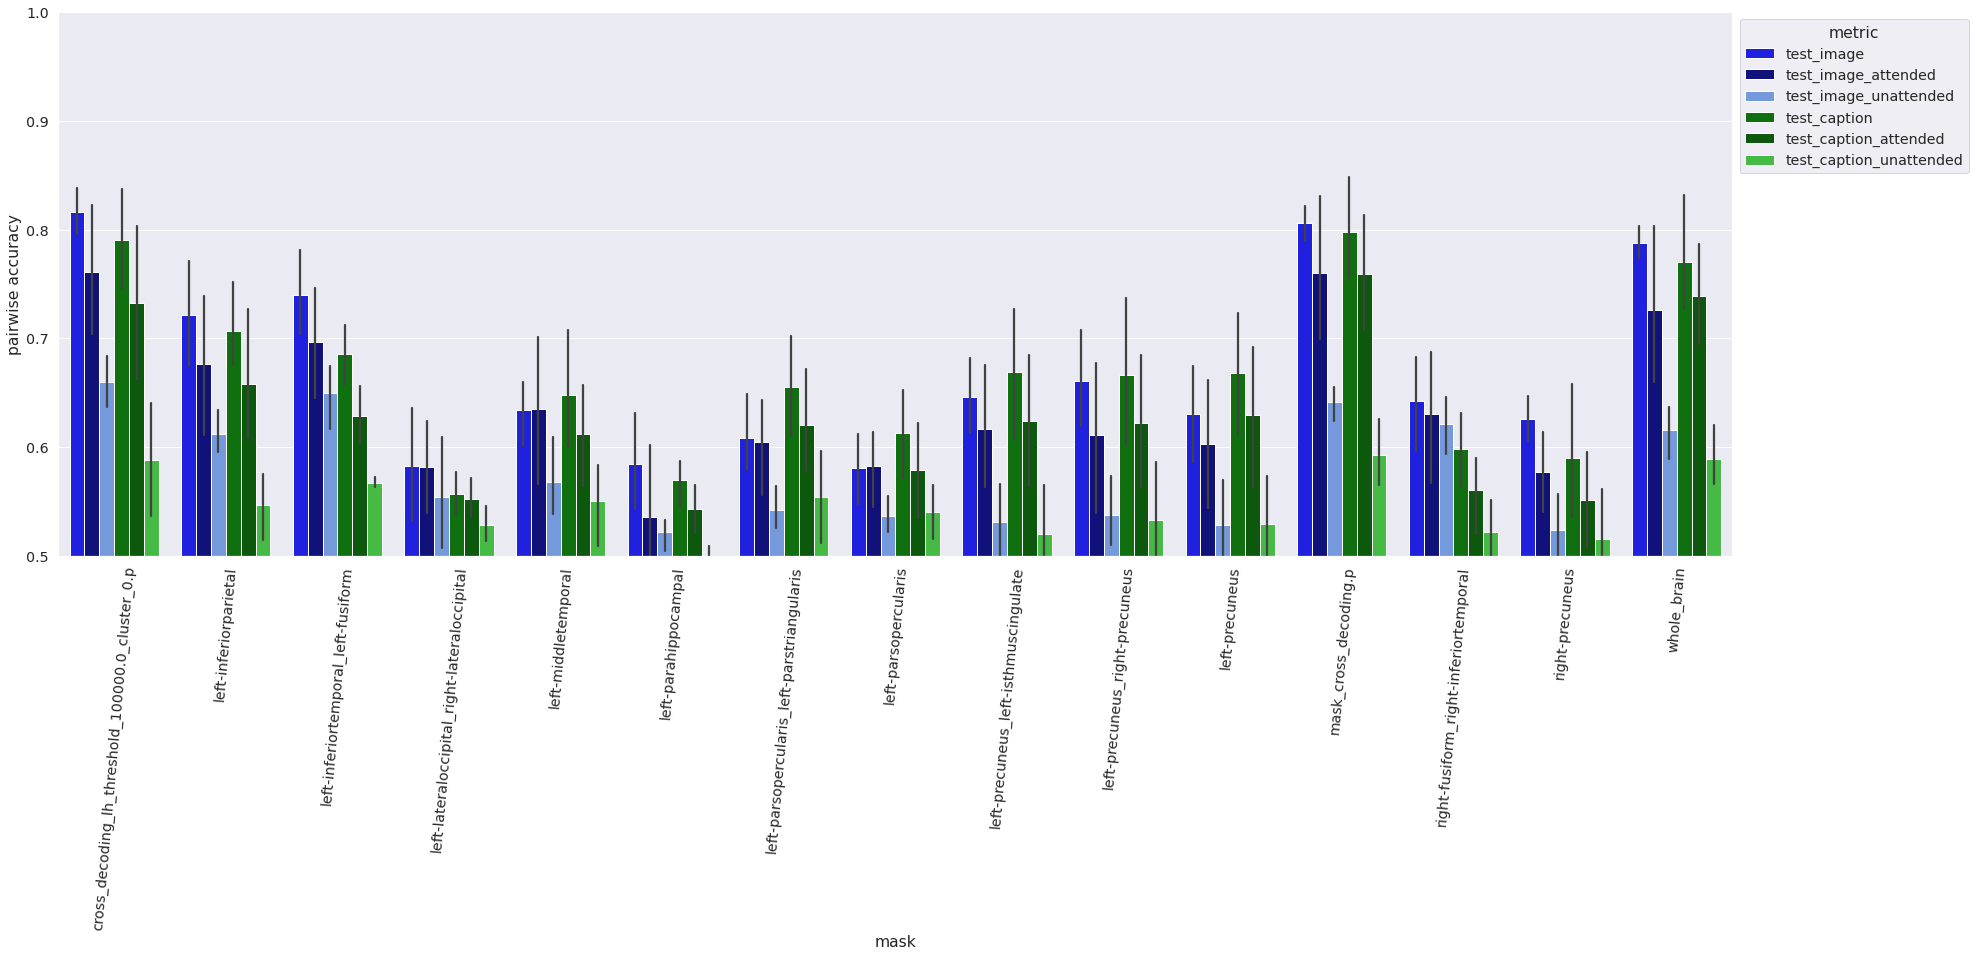

In [152]:
data = load_results_data()

filtered = data.copy()

# METRIC = "imagery"
# TRAINING_MODE = 'agnostic'
# TRAINING_MODE = 'images'
TRAINING_MODE = 'captions'

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
# MASK = 'whole_brain'

filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.latents == LATENT_MODE]
# filtered = filtered[filtered['mask'] == MASK]

filtered = filtered[filtered.training_mode == TRAINING_MODE]
# filtered = filtered[filtered.metric == METRIC]

def shorten_mask_name(name):
    if name == "whole_brain":
        return name
    return os.path.basename(name)
    
filtered["mask"] = filtered["mask"].apply(shorten_mask_name)


# print(filtered.groupby(['metric', 'mask']).agg(num_subjects=('value', 'size')).reset_index())
assert len(filtered) == len(ATTENTION_MOD_SUBJECTS) * len(filtered.metric.unique()) * len(filtered['mask'].unique())


HUE_ORDER = ['test_image', 'test_image_attended', 'test_image_unattended', 'test_caption', 'test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak']
PALETTE = ['blue', 'darkblue', 'cornflowerblue', 'green', 'darkgreen', 'limegreen', 'red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(30,10))
ax = sns.barplot(data=filtered, x="mask", y="value", hue="metric", hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.xticks(rotation=85)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

